# **Unsupervised - SetNo1**

**Set No. 1**

| Index                    | Description                                                                                                                   |
|--------------------------|-------------------------------------------------------------------------------------------------------------------------------|
| Recording Duration:      | October 22, 2003 12:06:24 to November 25, 2003 23:39:56                                                                       |
| No. of Files:            | 2,156                                                                                                                         |
| No. of Channels:         | 8                                                                                                                             |
| Channel Arrangement:     | Bearing 1 – Ch 1&2; Bearing 2 – Ch 3&4; Bearing 3 – Ch 5&6; Bearing 4 – Ch 7&8.                                               |
| File Recording Interval: | Every 10 minutes (except the first 43 files were taken every 5 minutes)                                                       |
| File Format:             | ASCII                                                                                                                         |
| Description:             | At the end of the test-to-failure experiment, inner race defect occurred in bearing 3 and roller element defect in bearing 4. |


Import Required Modules

In [1]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
import warnings

warnings.filterwarnings("ignore")
sns.set_theme(color_codes=True)
%matplotlib inline

2025-02-20 10:10:19.743349: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-20 10:10:20.542018: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2025-02-20 10:10:20.542141: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2025-02-20 10:10:20.542150: W tensorflow/compiler/tf2tensorrt/util

Load Data File for Test 2, Merged

In [2]:
merged_data = pd.read_csv('ProcessedData/MergedData/DatasetBearingTest_1.csv')
merged_data.rename(columns={'Unnamed: 0':'time'}, inplace=True)
merged_data.time = pd.to_datetime(merged_data['time'], format='%Y-%m-%d %H:%M:%S')
merged_data.index=merged_data['time']
merged_data = merged_data.sort_index()
merged_data.drop(columns=['time'], inplace=True)
merged_data

Bearing 1x  Bearing 1y  Bearing 2x  Bearing 2y  \
time                                                                  
2003-10-22 12:06:24    0.104148    0.100253    0.107147    0.102004   
2003-10-22 12:09:13    0.103651    0.099854    0.108189    0.102920   
2003-10-22 12:14:13    0.105039    0.101543    0.108543    0.104042   
2003-10-22 12:19:13    0.104900    0.101573    0.108152    0.103378   
2003-10-22 12:24:13    0.104779    0.102181    0.107943    0.102629   
...                         ...         ...         ...         ...   
2003-11-25 16:07:32    0.138784    0.130001    0.151358    0.138561   
2003-11-25 23:13:21    0.142147    0.131042    0.162772    0.149214   
2003-11-25 23:19:56    0.142098    0.131348    0.167258    0.154300   
2003-11-25 23:29:56    0.141889    0.132988    0.158432    0.153226   
2003-11-25 23:39:56    0.142014    0.131698    0.170618    0.162325   

                     Bearing 3x  Bearing 3y  Bearing 4x  Bearing 4y  
time                                                                 
2003-10-22 12:06:24    0.106149    0.108150    0.094803    0.099513  
2003-10-22 12:09:13    0.106661    0.108458    0.095070    0.093587  
2003-10-22 12:14:13    0.108740    0.109875    0.096158    0.098299  
2003-10-22 12:19:13    0.108068    0.110010    0.096814    0.098602  
2003-10-22 12:24:13    0.108454    0.109350    0.096358    0.098471  
...                         ...         ...         ...         ...  
2003-11-25 16:07:32    0.209843    0.217346    0.165271    0.154710  
2003-11-25 23:13:21    0.339327    0.330122    0.175640    0.163224  
2003-11-25 23:19:56    0.357823    0.351640    0.184356    0.165720  
2003-11-25 23:29:56    0.331172    0.335432    0.174025    0.161537  
2003-11-25 23:39:56    0.438427    0.364037    0.181261    0.168055  

[2156 rows x 8 columns]

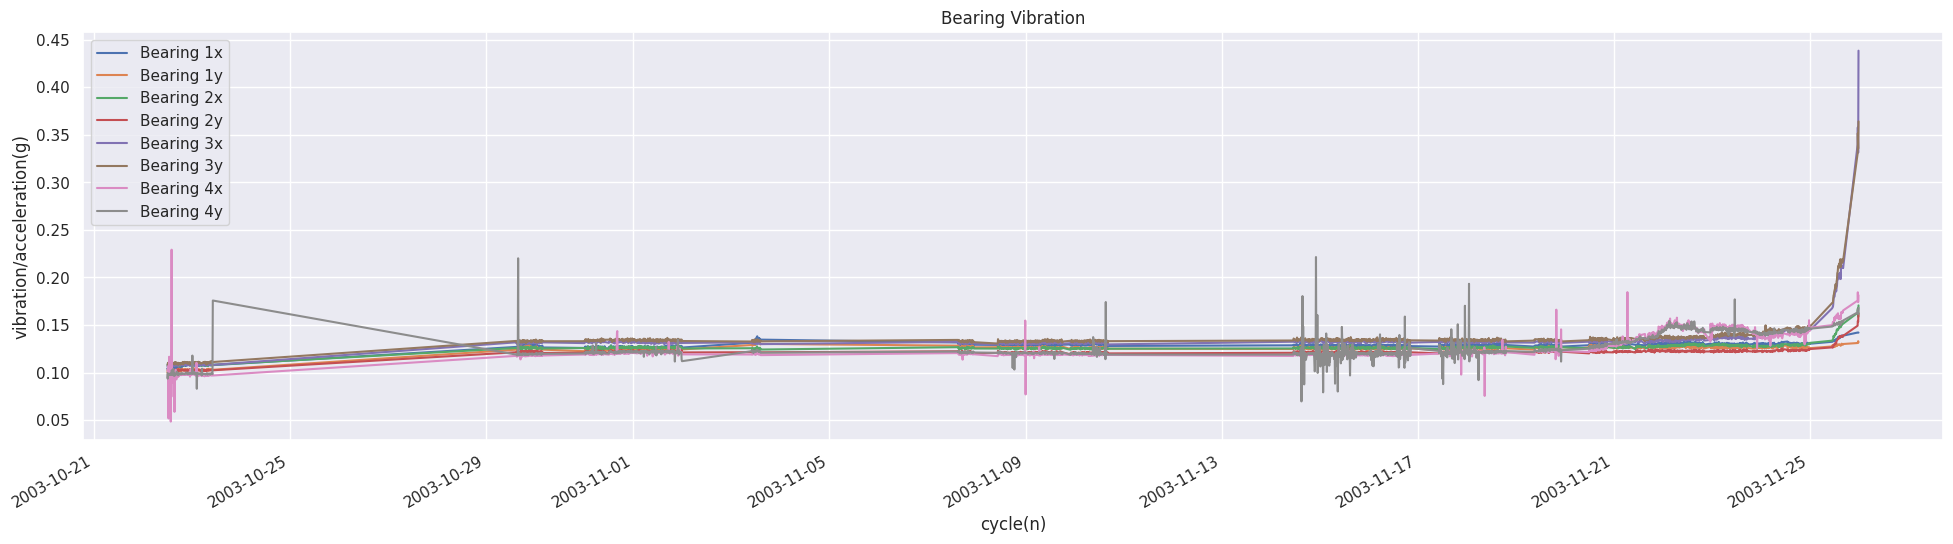

In [3]:
ax = merged_data.plot(figsize = (24,6), title= "Bearing Vibration" , legend = True)
ax.set(xlabel="cycle(n)", ylabel="vibration/acceleration(g)")
plt.show()

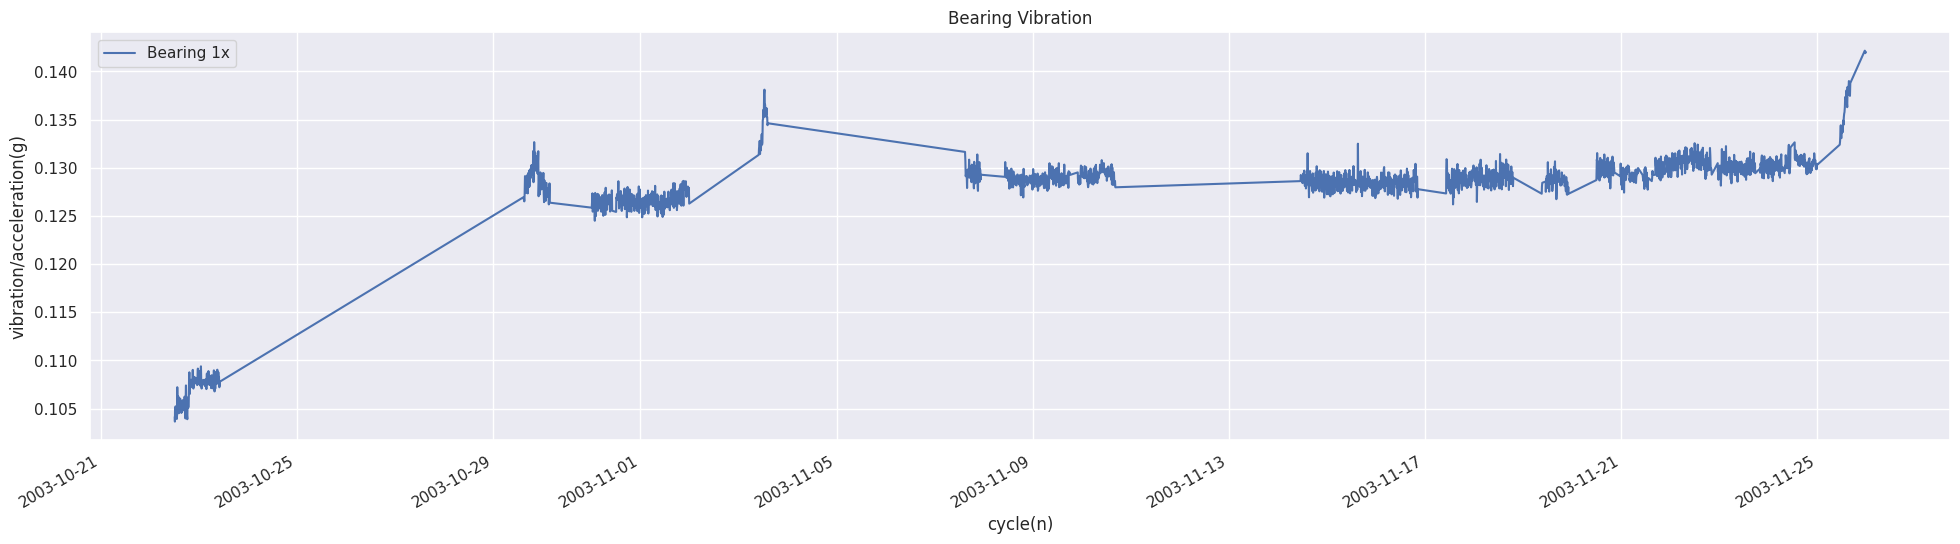

In [4]:
ax = merged_data.iloc[:,0].plot(figsize = (24,6), title= "Bearing Vibration" , legend = True)
ax.set(xlabel="cycle(n)", ylabel="vibration/acceleration(g)")
plt.show()

Split Data into Train and Test

In [5]:
split_index = int(0.7 * len(merged_data))

In [6]:
train_data = merged_data.iloc[:split_index]
test_data = merged_data.iloc[split_index:]

In [7]:
train_data.shape, test_data.shape

((1509, 8), (647, 8))

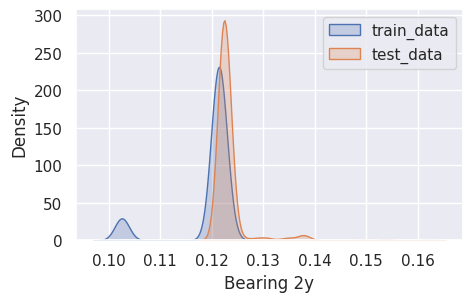

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 train_data 和 test_data 已经定义
train_column = train_data.iloc[:, 3]
test_column = test_data.iloc[:, 3]

# 创建一个图形
plt.figure(figsize=(5, 3))

# 使用 seaborn 的 kdeplot 来绘制核密度估计图
sns.kdeplot(train_column, label='train_data', shade=True)
sns.kdeplot(test_column, label='test_data', shade=True)

# # 添加标题和标签
# plt.title('训练数据和测试数据的第一列分布')
# plt.xlabel('值')
# plt.ylabel('密度')

# 添加图例
plt.legend()

# 显示图形
plt.show()

Normalize Data

In [9]:
scaler = preprocessing.MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns, index=train_data.index)
X_test = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns, index=test_data.index)

In [10]:
X_train.max(), X_train.min()

(Bearing 1x    1.0
 Bearing 1y    1.0
 Bearing 2x    1.0
 Bearing 2y    1.0
 Bearing 3x    1.0
 Bearing 3y    1.0
 Bearing 4x    1.0
 Bearing 4y    1.0
 dtype: float64,
 Bearing 1x    0.0
 Bearing 1y    0.0
 Bearing 2x    0.0
 Bearing 2y    0.0
 Bearing 3x    0.0
 Bearing 3y    0.0
 Bearing 4x    0.0
 Bearing 4y    0.0
 dtype: float64)

In [11]:
X_test.max(), X_test.min()

(Bearing 1x     1.117407
 Bearing 1y     1.006388
 Bearing 2x     2.703278
 Bearing 2y     2.445700
 Bearing 3x    11.301572
 Bearing 3y     8.794181
 Bearing 4x     0.752975
 Bearing 4y     0.706792
 dtype: float64,
 Bearing 1x    0.689918
 Bearing 1y    0.754055
 Bearing 2x    0.760629
 Bearing 2y    0.775653
 Bearing 3x    0.827428
 Bearing 3y    0.859432
 Bearing 4x    0.410071
 Bearing 4y    0.366082
 dtype: float64)

Isolation Forest

In [12]:
X_train.shape, X_test.shape

((1509, 8), (647, 8))

In [ ]:
import numpy as np
import plotly.express as px
from sklearn.manifold import TSNE

# 假設 X_train, X_test 已經定義
# 這裡用隨機數據來模擬你的資料
np.random.seed(42)
# X_train = np.random.rand(1509, 8)
# X_test = np.random.rand(647, 8)

# 合併數據以便一起降維
X_combined = np.vstack([X_train, X_test])
labels = np.array(["Train"] * len(X_train) + ["Test"] * len(X_test))

# 使用 t-SNE 進行降維 (8D -> 3D)
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(X_combined)

# 建立 DataFrame 來繪圖
data = {
    "x": X_embedded[:, 0],
    "y": X_embedded[:, 1],
    "z": X_embedded[:, 2],
    "Dataset": labels
}

# 使用 Plotly 繪製 3D 散點圖
fig = px.scatter_3d(
    data, x="x", y="y", z="z", color="Dataset",
    title="t-SNE Visualization of Train and Test Data",
    labels={"Dataset": "Data Type"}
)
fig.show()

In [14]:
iso_forest = IsolationForest(n_estimators=1000, contamination='auto', random_state=42)
iso_forest.fit(X_train)

IsolationForest(n_estimators=1000, random_state=42)

Get anomaly scores and predictions for the train and test data

iso_forest.predict: == 1 for normal, == -1 for anomaly

In [15]:
# Get anomaly scores and predictions for the train and test data
train_scores = iso_forest.decision_function(X_train)
train_anomalies = iso_forest.predict(X_train)
test_scores = iso_forest.decision_function(X_test)
test_anomalies = iso_forest.predict(X_test)

In [16]:
train_anomalies.shape, test_anomalies.shape

((1509,), (647,))

In [17]:
train_anomalies

array([-1, -1, -1, ...,  1,  1,  1])

In [18]:
test_anomalies[:5]

array([ 1, -1,  1, -1, -1])

In [19]:
iso_forest_results = pd.DataFrame(index=X_train.index.append(X_test.index))
iso_forest_results['Score'] = np.concatenate([train_scores, test_scores])
iso_forest_results['Anomaly'] = np.concatenate([train_anomalies, test_anomalies])

In [20]:
iso_forest_results['Anomaly']

time
2003-10-22 12:06:24   -1
2003-10-22 12:09:13   -1
2003-10-22 12:14:13   -1
2003-10-22 12:19:13   -1
2003-10-22 12:24:13   -1
                      ..
2003-11-25 16:07:32   -1
2003-11-25 23:13:21   -1
2003-11-25 23:19:56   -1
2003-11-25 23:29:56   -1
2003-11-25 23:39:56   -1
Name: Anomaly, Length: 2156, dtype: int64

In [21]:
iso_forest_results['Anomaly'] = iso_forest_results['Anomaly'] == -1
iso_forest_results['Anomaly']

time
2003-10-22 12:06:24    True
2003-10-22 12:09:13    True
2003-10-22 12:14:13    True
2003-10-22 12:19:13    True
2003-10-22 12:24:13    True
                       ... 
2003-11-25 16:07:32    True
2003-11-25 23:13:21    True
2003-11-25 23:19:56    True
2003-11-25 23:29:56    True
2003-11-25 23:39:56    True
Name: Anomaly, Length: 2156, dtype: bool

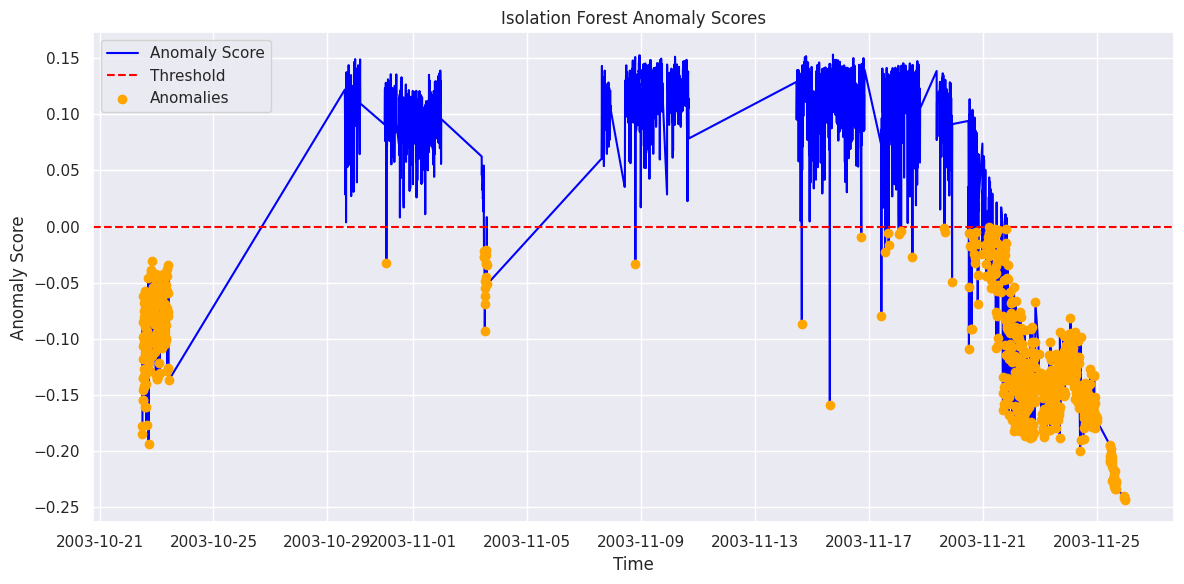

In [22]:
plt.figure(figsize=(12,6))
plt.plot(iso_forest_results.index, iso_forest_results['Score'], label='Anomaly Score', color='blue')
plt.axhline(y=0, color='red', linestyle='--', label='Threshold')
plt.scatter(iso_forest_results[iso_forest_results['Anomaly']].index,
            iso_forest_results[iso_forest_results['Anomaly']]['Score'],
            color='orange', label='Anomalies', zorder=5)
plt.title('Isolation Forest Anomaly Scores')
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [23]:
merged_data.columns

Index(['Bearing 1x', 'Bearing 1y', 'Bearing 2x', 'Bearing 2y', 'Bearing 3x',
       'Bearing 3y', 'Bearing 4x', 'Bearing 4y'],
      dtype='object')

In [24]:
merged_data['Anomaly_ISO'] = iso_forest_results['Anomaly']

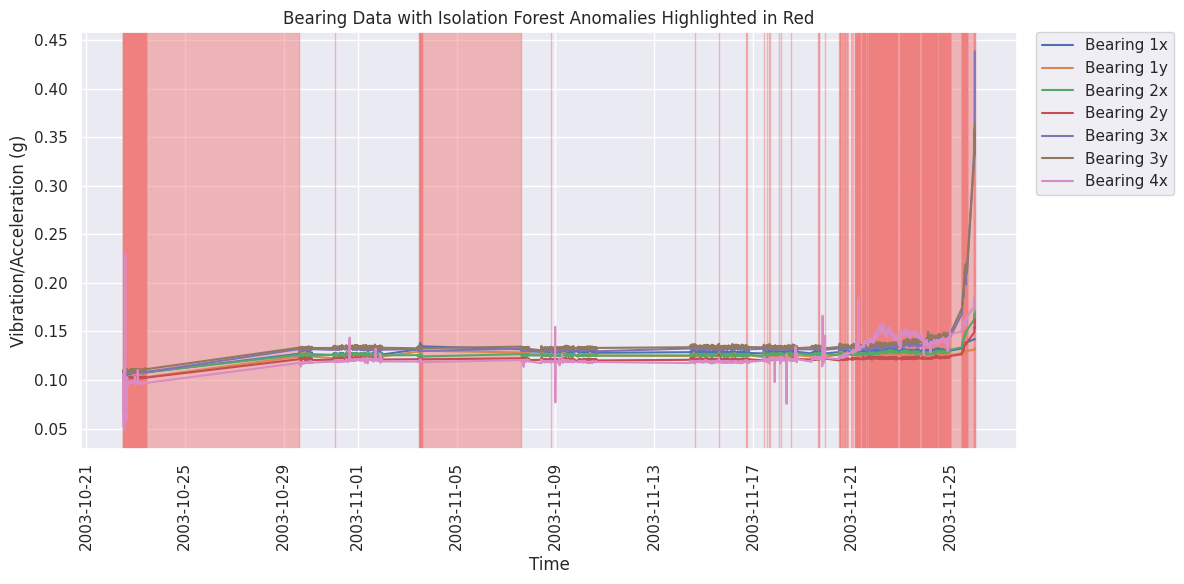

In [27]:
plt.figure(figsize=(12, 6))

for col in merged_data.columns[:-2]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_ISO'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with Isolation Forest Anomalies Highlighted in Red")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

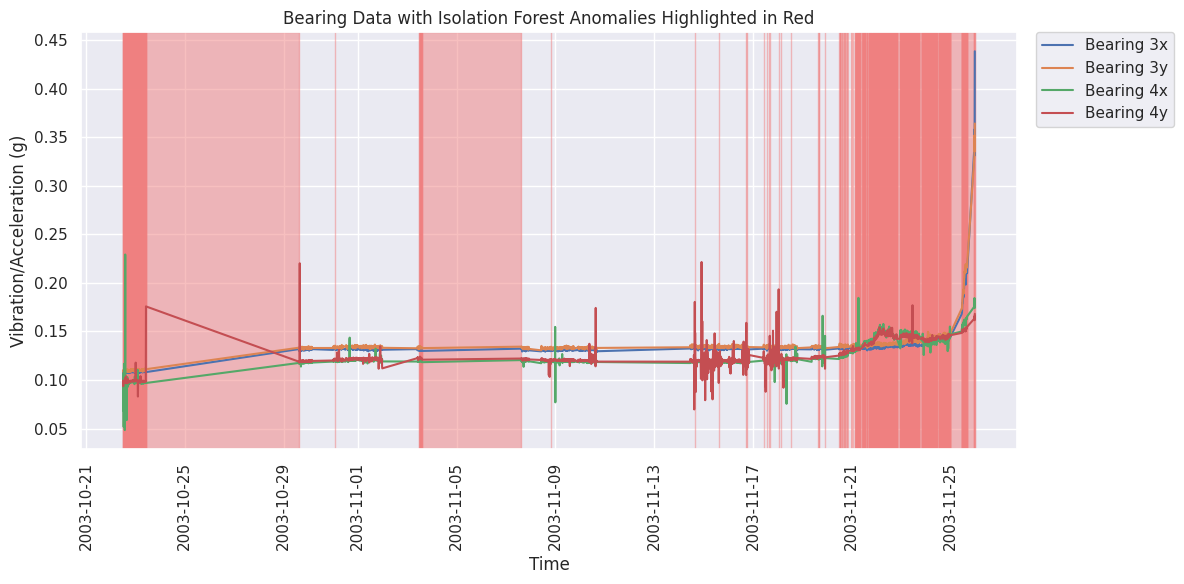

In [28]:
plt.figure(figsize=(12, 6))

for col in merged_data.columns[4:-1]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_ISO'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with Isolation Forest Anomalies Highlighted in Red")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

It is detecting too many anomalies, so we will proceed with further experimentation.

In [29]:
#set contamination to a lower value, e.g., 0.01 (1% of the data)
iso_forest = IsolationForest(n_estimators=200, contamination=0.009, random_state=42)
iso_forest.fit(X_train)

train_scores = iso_forest.decision_function(X_train)
train_anomalies = iso_forest.predict(X_train)
test_scores = iso_forest.decision_function(X_test)
test_anomalies = iso_forest.predict(X_test)

iso_forest_results = pd.DataFrame(index=X_train.index.append(X_test.index))
iso_forest_results['Score'] = np.concatenate([train_scores, test_scores])
iso_forest_results['Anomaly'] = np.concatenate([train_anomalies, test_anomalies])
iso_forest_results['Anomaly'] = iso_forest_results['Anomaly'] == -1

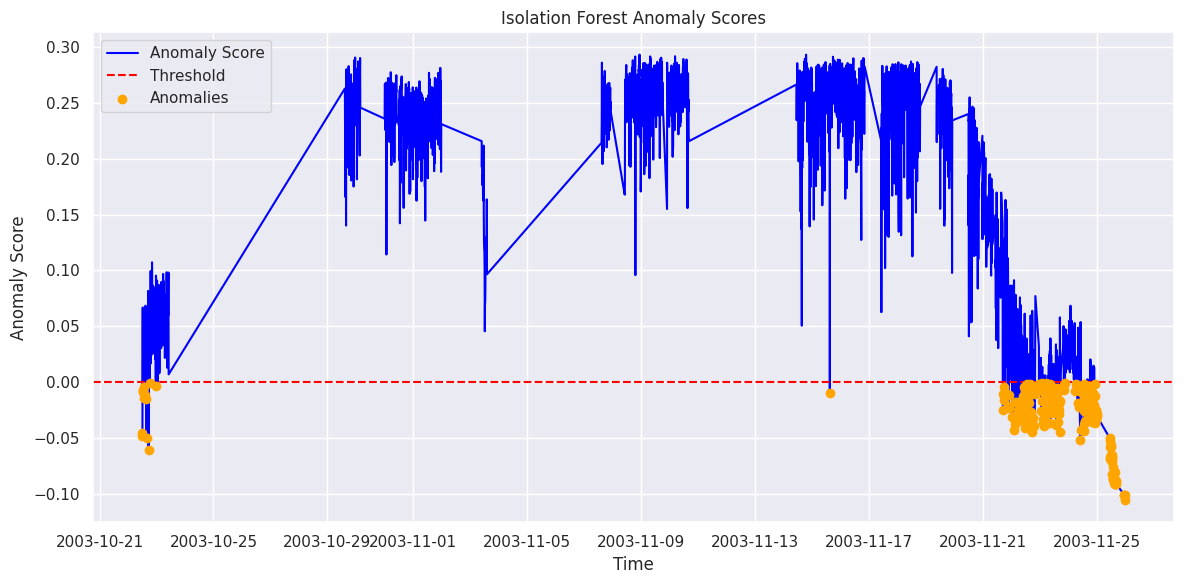

In [30]:
plt.figure(figsize=(12,6))
plt.plot(iso_forest_results.index, iso_forest_results['Score'], label='Anomaly Score', color='blue')
plt.axhline(y=0, color='red', linestyle='--', label='Threshold')
plt.scatter(iso_forest_results[iso_forest_results['Anomaly']].index,
            iso_forest_results[iso_forest_results['Anomaly']]['Score'],
            color='orange', label='Anomalies', zorder=5)
plt.title('Isolation Forest Anomaly Scores')
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

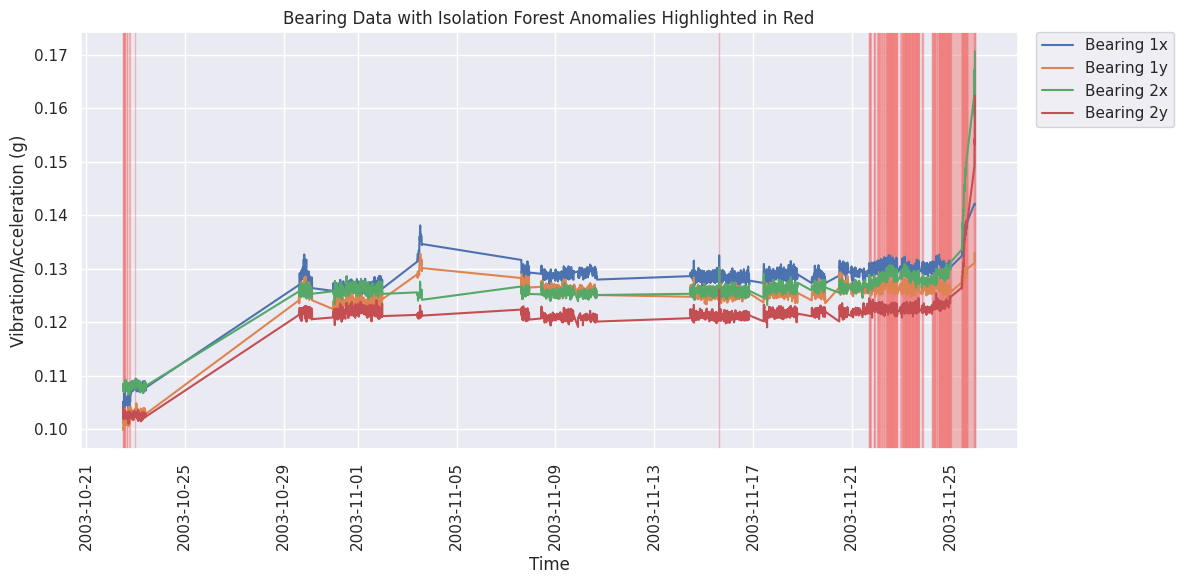

In [31]:
merged_data['Anomaly_ISO'] = iso_forest_results['Anomaly']

plt.figure(figsize=(12, 6))

for col in merged_data.columns[:4]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_ISO'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with Isolation Forest Anomalies Highlighted in Red")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

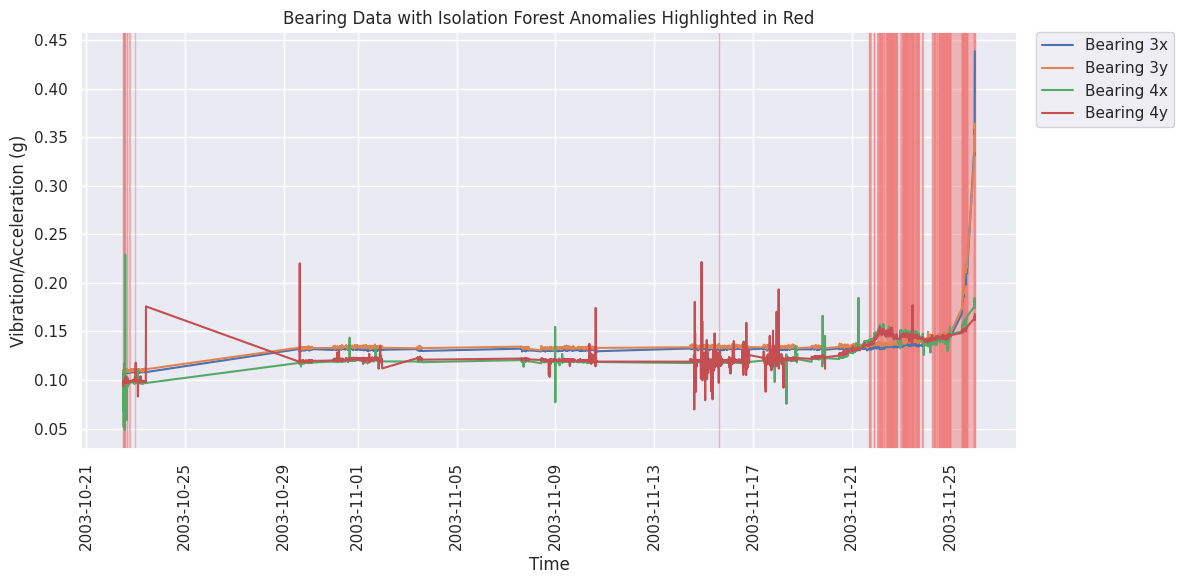

In [32]:
plt.figure(figsize=(12, 6))

for col in merged_data.columns[4:8]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_ISO'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with Isolation Forest Anomalies Highlighted in Red")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

Lets test with a number of contamination values

In [33]:
contamination_values = [0.005, 0.01, 0.02, 0.05]

for contamination in contamination_values:
    iso_forest = IsolationForest(n_estimators=100, contamination=contamination, random_state=42)
    iso_forest.fit(X_train)
    total_anomalies = sum(iso_forest.predict(X_test) == -1)
    print(f"Contamination: {contamination}, Total Anomalies Detected: {total_anomalies}")

Contamination: 0.005, Total Anomalies Detected: 213
Contamination: 0.01, Total Anomalies Detected: 253
Contamination: 0.02, Total Anomalies Detected: 329
Contamination: 0.05, Total Anomalies Detected: 418


Adjust n_estimators and max_samples

In [34]:
iso_forest = IsolationForest(
    n_estimators=200,
    max_samples='auto',
    contamination=0.01,
    random_state=42
)
iso_forest.fit(X_train)

IsolationForest(contamination=0.01, n_estimators=200, random_state=42)

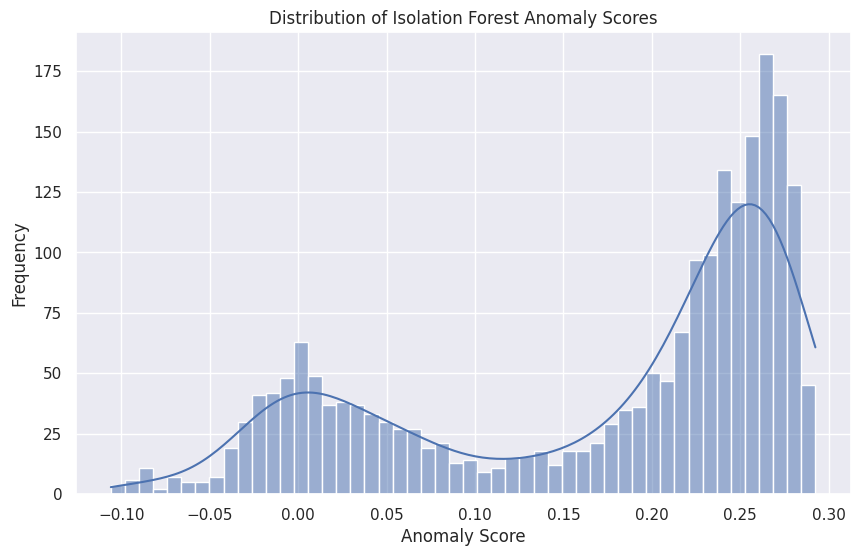

In [35]:
#calculate anomaly scores
scores = iso_forest.decision_function(pd.concat([X_train, X_test]))

#plot the distribution of scores
plt.figure(figsize=(10,6))
sns.histplot(scores, bins=50, kde=True)
plt.title('Distribution of Isolation Forest Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()

In [36]:
threshold = np.percentile(scores, 3)
print(f"Custom Threshold: {threshold}")

iso_forest_results['Anomaly_Custom'] = iso_forest_results['Score'] < threshold

Custom Threshold: -0.03436646493028443


Plotting with Adjusted Anomalies

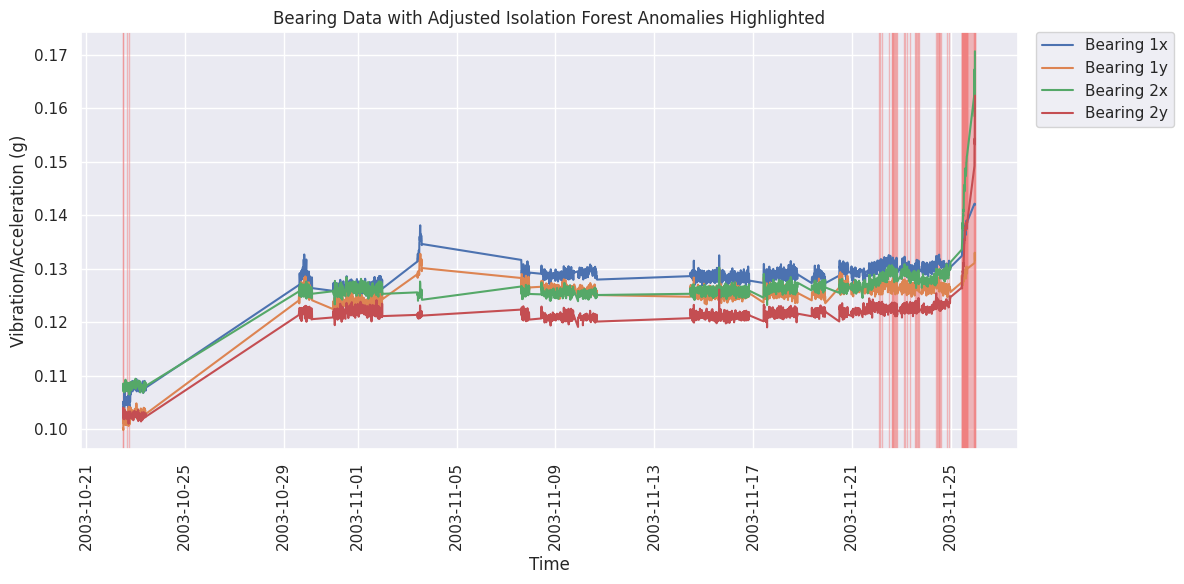

In [37]:
merged_data['Anomaly_ISO'] = iso_forest_results['Anomaly_Custom'].values

plt.figure(figsize=(12, 6))

for col in merged_data.columns[:4]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_ISO'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with Adjusted Isolation Forest Anomalies Highlighted")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

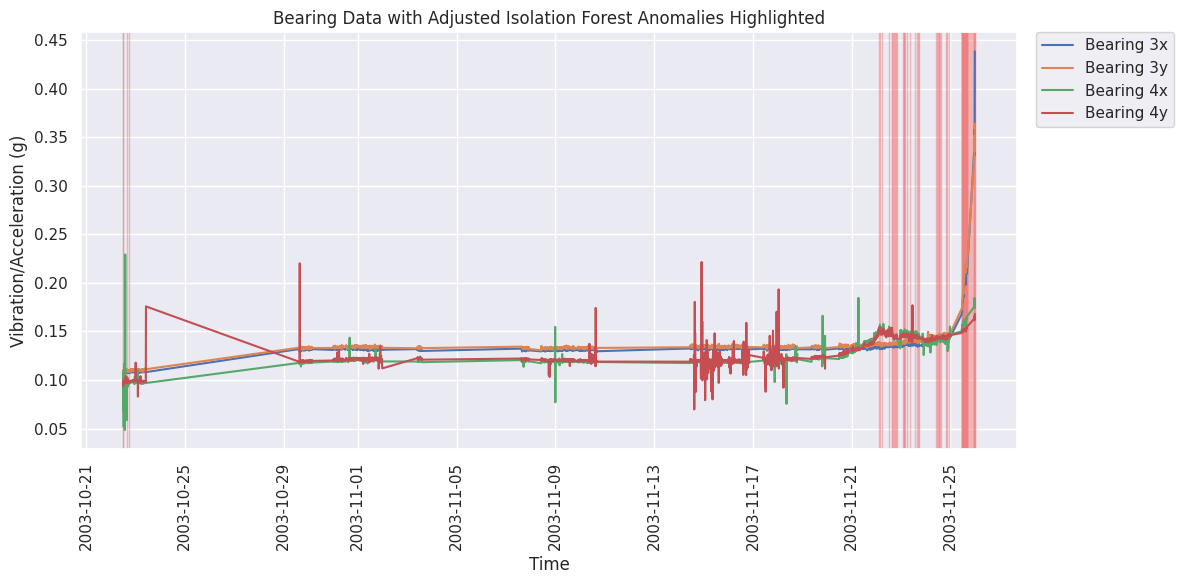

In [39]:
merged_data['Anomaly_ISO'] = iso_forest_results['Anomaly_Custom'].values

plt.figure(figsize=(12, 6))

for col in merged_data.columns[4:8]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_ISO'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with Adjusted Isolation Forest Anomalies Highlighted")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

In [40]:
merged_data

Bearing 1x  Bearing 1y  Bearing 2x  Bearing 2y  \
time                                                                  
2003-10-22 12:06:24    0.104148    0.100253    0.107147    0.102004   
2003-10-22 12:09:13    0.103651    0.099854    0.108189    0.102920   
2003-10-22 12:14:13    0.105039    0.101543    0.108543    0.104042   
2003-10-22 12:19:13    0.104900    0.101573    0.108152    0.103378   
2003-10-22 12:24:13    0.104779    0.102181    0.107943    0.102629   
...                         ...         ...         ...         ...   
2003-11-25 16:07:32    0.138784    0.130001    0.151358    0.138561   
2003-11-25 23:13:21    0.142147    0.131042    0.162772    0.149214   
2003-11-25 23:19:56    0.142098    0.131348    0.167258    0.154300   
2003-11-25 23:29:56    0.141889    0.132988    0.158432    0.153226   
2003-11-25 23:39:56    0.142014    0.131698    0.170618    0.162325   

                     Bearing 3x  Bearing 3y  Bearing 4x  Bearing 4y  \
time                                                                  
2003-10-22 12:06:24    0.106149    0.108150    0.094803    0.099513   
2003-10-22 12:09:13    0.106661    0.108458    0.095070    0.093587   
2003-10-22 12:14:13    0.108740    0.109875    0.096158    0.098299   
2003-10-22 12:19:13    0.108068    0.110010    0.096814    0.098602   
2003-10-22 12:24:13    0.108454    0.109350    0.096358    0.098471   
...                         ...         ...         ...         ...   
2003-11-25 16:07:32    0.209843    0.217346    0.165271    0.154710   
2003-11-25 23:13:21    0.339327    0.330122    0.175640    0.163224   
2003-11-25 23:19:56    0.357823    0.351640    0.184356    0.165720   
2003-11-25 23:29:56    0.331172    0.335432    0.174025    0.161537   
2003-11-25 23:39:56    0.438427    0.364037    0.181261    0.168055   

                     Anomaly_ISO  
time                              
2003-10-22 12:06:24         True  
2003-10-22 12:09:13         True  
2003-10-22 12:14:13        False  
2003-10-22 12:19:13        False  
2003-10-22 12:24:13        False  
...                          ...  
2003-11-25 16:07:32         True  
2003-11-25 23:13:21         True  
2003-11-25 23:19:56         True  
2003-11-25 23:29:56         True  
2003-11-25 23:39:56         True  

[2156 rows x 9 columns]

In [65]:
import numpy as np
import plotly.express as px
from sklearn.manifold import TSNE

# 假設 X_train, X_test 已經定義
# 這裡用隨機數據來模擬你的資料
np.random.seed(42)

# 合併數據以便一起降維
datas = merged_data.iloc[:, :8].values
labels = merged_data['Anomaly_ISO']

# 使用 t-SNE 進行降維 (8D -> 3D)
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(datas)

# 建立 DataFrame 來繪圖
data = {
    "x": X_embedded[:, 0],
    "y": X_embedded[:, 1],
    "z": X_embedded[:, 2],
    "Dataset": labels
}

# 使用 Plotly 繪製 3D 散點圖
fig = px.scatter_3d(
    data, x="x", y="y", z="z", color="Dataset",
    title="t-SNE Visualization of Anomaly_ISO",
    labels={"Dataset": "Data Type"},
    color_discrete_map={False: "blue", True: "red"}
)
fig.update_traces(marker=dict(size=3))  # 調整點的大小
fig.show()

This is more better.

# **One-Class SVM**

In [46]:
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
ocsvm.fit(X_train)

OneClassSVM(gamma='auto', nu=0.05)

In [47]:
train_scores = ocsvm.decision_function(X_train)
train_anomalies = ocsvm.predict(X_train)
test_scores = ocsvm.decision_function(X_test)
test_anomalies = ocsvm.predict(X_test)

In [48]:
ocsvm_results = pd.DataFrame(index=X_train.index.append(X_test.index))
ocsvm_results['Score'] = np.concatenate([train_scores, test_scores])
ocsvm_results['Anomaly'] = np.concatenate([train_anomalies, test_anomalies])

#anomalies are marked as -1, normal as 1
ocsvm_results['Anomaly'] = ocsvm_results['Anomaly'] == -1

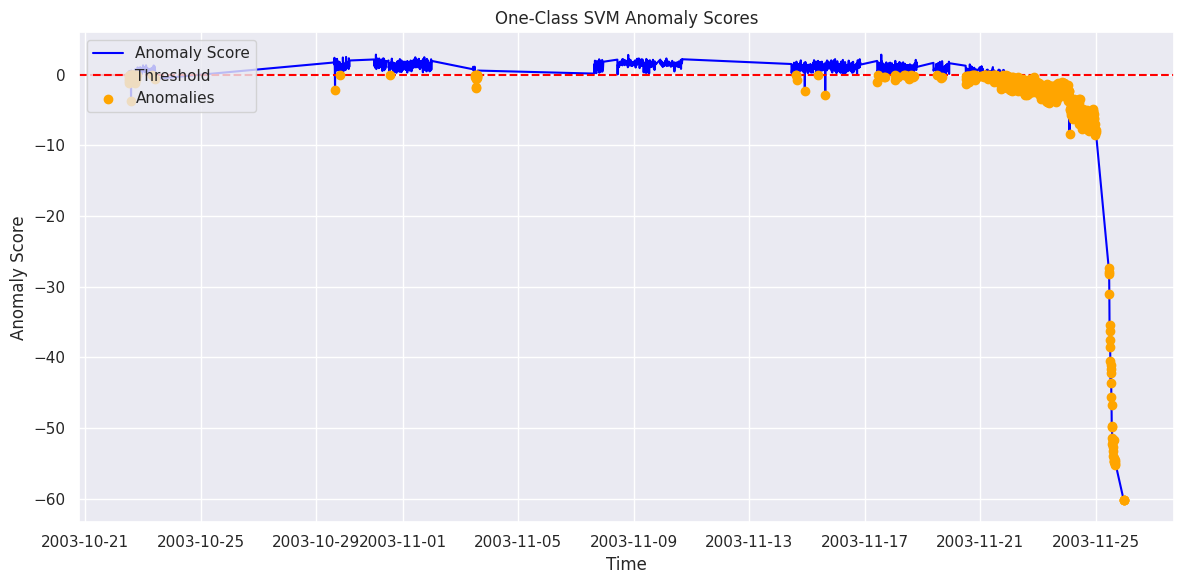

In [49]:
plt.figure(figsize=(12,6))
plt.plot(ocsvm_results.index, ocsvm_results['Score'], label='Anomaly Score', color='blue')
plt.axhline(y=0, color='red', linestyle='--', label='Threshold')
plt.scatter(ocsvm_results[ocsvm_results['Anomaly']].index,
            ocsvm_results[ocsvm_results['Anomaly']]['Score'],
            color='orange', label='Anomalies', zorder=5)
plt.title('One-Class SVM Anomaly Scores')
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

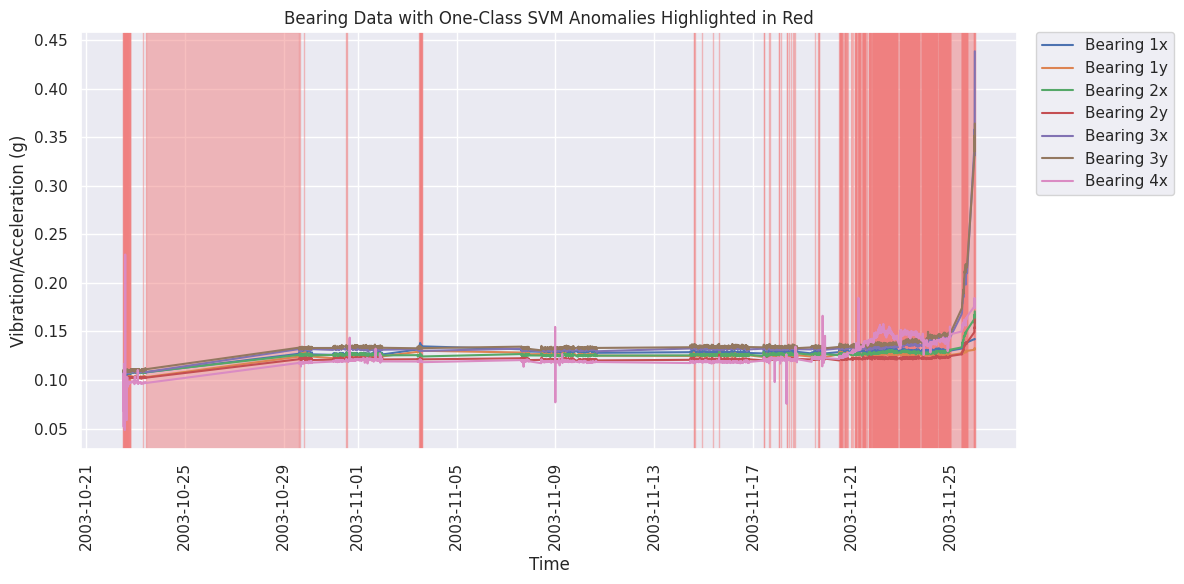

In [50]:
merged_data['Anomaly_OCSVM'] = ocsvm_results['Anomaly']

plt.figure(figsize=(12, 6))

for col in merged_data.columns[:-3]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_OCSVM'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with One-Class SVM Anomalies Highlighted in Red")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

this is getting a whole lot of anoalies, so it needs to be adjusted as well.

Adjust the nu Parameter

In [51]:
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.005)  #try nu = 0.005 or even lower
ocsvm.fit(X_train)

train_scores = ocsvm.decision_function(X_train)
train_anomalies = ocsvm.predict(X_train)
test_scores = ocsvm.decision_function(X_test)
test_anomalies = ocsvm.predict(X_test)

combined_index = X_train.index.append(X_test.index)
ocsvm_results = pd.DataFrame(index=combined_index)
ocsvm_results['Score'] = np.concatenate([train_scores, test_scores])
ocsvm_results['Anomaly'] = np.concatenate([train_anomalies, test_anomalies])

# Convert predictions: anomalies are marked as -1
ocsvm_results['Anomaly'] = ocsvm_results['Anomaly'] == -1

ocsvm_results['Score'] = np.concatenate([train_scores, test_scores])
ocsvm_results['Anomaly'] = np.concatenate([train_anomalies, test_anomalies])
ocsvm_results['Anomaly'] = ocsvm_results['Anomaly'] == -1

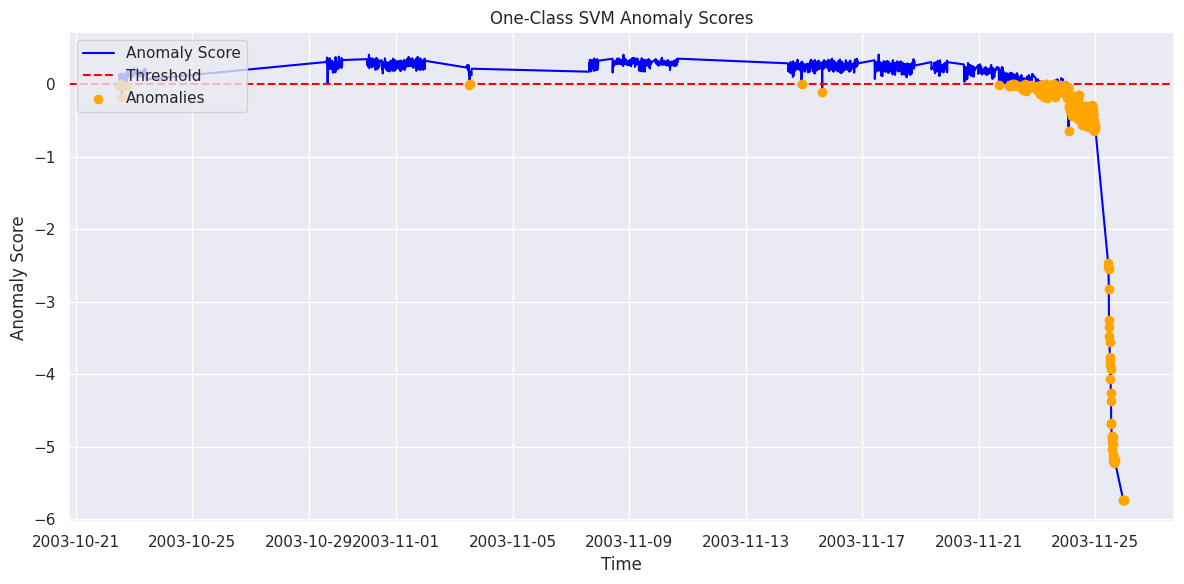

In [52]:
plt.figure(figsize=(12,6))
plt.plot(ocsvm_results.index, ocsvm_results['Score'], label='Anomaly Score', color='blue')
plt.axhline(y=0, color='red', linestyle='--', label='Threshold')
plt.scatter(ocsvm_results[ocsvm_results['Anomaly']].index,
            ocsvm_results[ocsvm_results['Anomaly']]['Score'],
            color='orange', label='Anomalies', zorder=5)
plt.title('One-Class SVM Anomaly Scores')
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

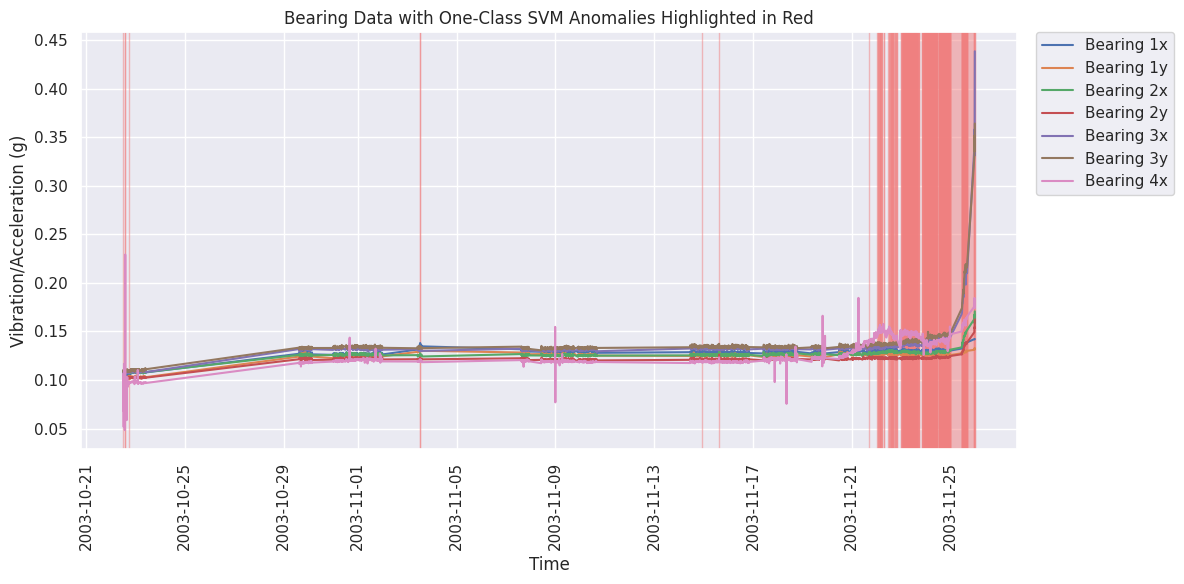

In [53]:
merged_data['Anomaly_OCSVM'] = ocsvm_results['Anomaly']

plt.figure(figsize=(12, 6))

for col in merged_data.columns[:-3]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_OCSVM'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with One-Class SVM Anomalies Highlighted in Red")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

Test other Kernel

In [54]:
ocsvm = OneClassSVM(kernel='rbf', gamma=0.01, nu=0.005)
ocsvm.fit(X_train)

OneClassSVM(gamma=0.01, nu=0.005)

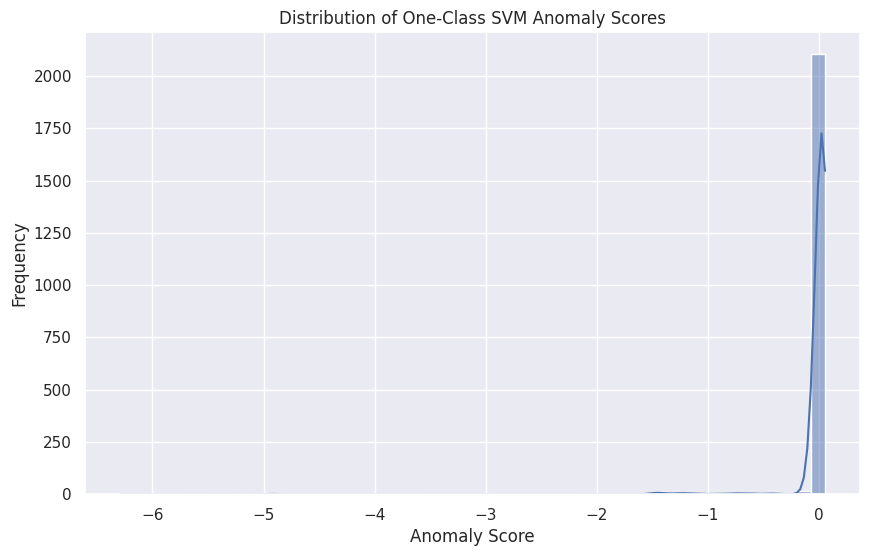

In [55]:
#calculate anomaly scores
scores = ocsvm.decision_function(pd.concat([X_train, X_test]))

#distribution of scores
plt.figure(figsize=(10,6))
sns.histplot(scores, bins=50, kde=True)
plt.title('Distribution of One-Class SVM Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()

In [56]:
threshold = np.percentile(scores, 3)
print(f"Custom Threshold: {threshold}")
ocsvm_results['Anomaly_Custom'] = ocsvm_results['Score'] < threshold
merged_data['Anomaly_OCSVM'] = ocsvm_results['Anomaly_Custom'].values

Custom Threshold: -0.06375610980187463


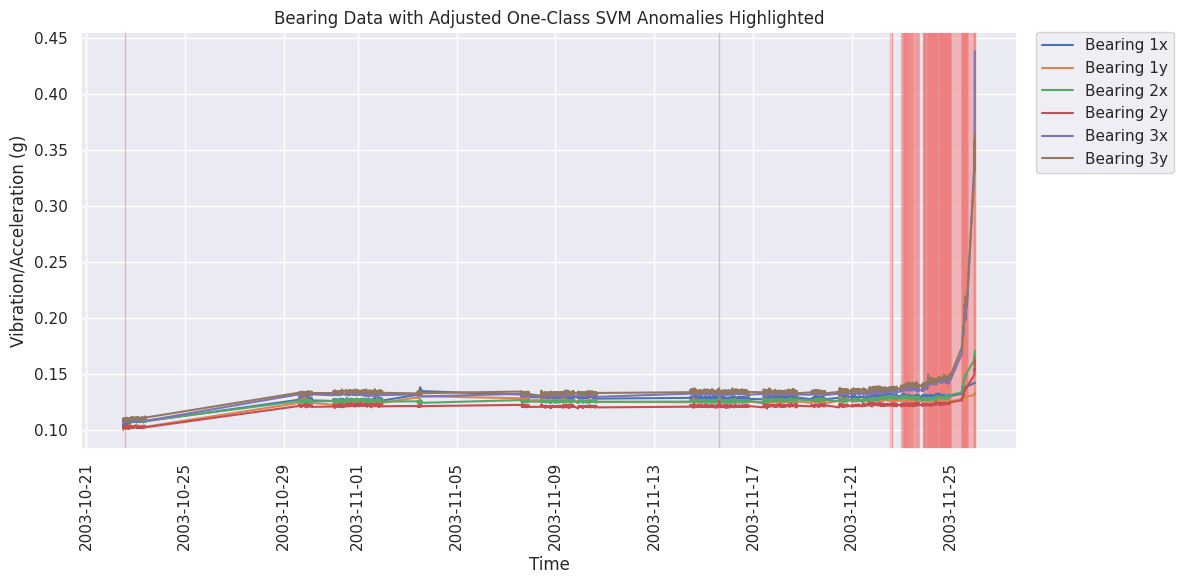

In [57]:
plt.figure(figsize=(12, 6))

for col in merged_data.columns[:-4]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_OCSVM'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with Adjusted One-Class SVM Anomalies Highlighted")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

In [64]:
import numpy as np
import plotly.express as px
from sklearn.manifold import TSNE

# 假設 X_train, X_test 已經定義
# 這裡用隨機數據來模擬你的資料
np.random.seed(42)

# 合併數據以便一起降維
datas = merged_data.iloc[:, :8].values
labels = merged_data['Anomaly_OCSVM']

# 使用 t-SNE 進行降維 (8D -> 3D)
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(datas)

# 建立 DataFrame 來繪圖
data = {
    "x": X_embedded[:, 0],
    "y": X_embedded[:, 1],
    "z": X_embedded[:, 2],
    "Dataset": labels
}

# 使用 Plotly 繪製 3D 散點圖
fig = px.scatter_3d(
    data, x="x", y="y", z="z", color="Dataset",
    title="t-SNE Visualization of Anomaly_OCSVM",
    labels={"Dataset": "Data Type"},
    color_discrete_map={False: "blue", True: "red"}
)
fig.update_traces(marker=dict(size=3))  # 調整點的大小
fig.show()

this look better.

# **Local Outlier Factor (LOF)**

In [68]:
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto', novelty=True)
lof.fit(X_train)

LocalOutlierFactor(novelty=True)

In [69]:
train_scores = lof.decision_function(X_train)
train_anomalies = lof.predict(X_train)
test_scores = lof.decision_function(X_test)
test_anomalies = lof.predict(X_test)

lof_results = pd.DataFrame(index=X_train.index.append(X_test.index))
lof_results['Score'] = np.concatenate([train_scores, test_scores])
lof_results['Anomaly'] = np.concatenate([train_anomalies, test_anomalies])

In [70]:
lof_results['Anomaly'] = lof_results['Anomaly'] == -1

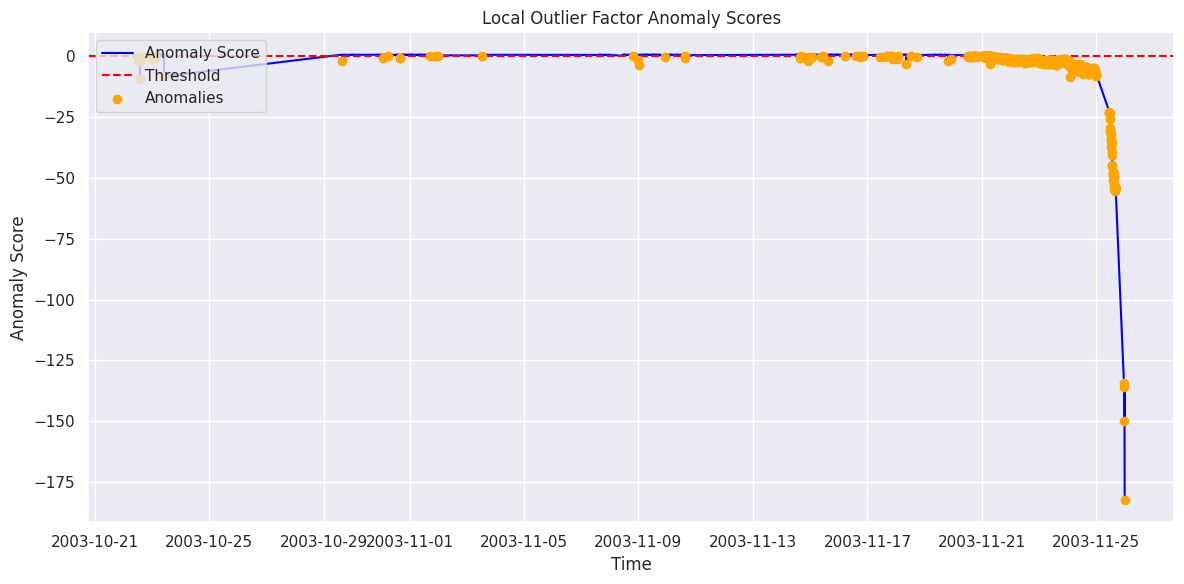

In [71]:
plt.figure(figsize=(12,6))
plt.plot(lof_results.index, lof_results['Score'], label='Anomaly Score', color='blue')
plt.axhline(y=0, color='red', linestyle='--', label='Threshold')
plt.scatter(lof_results[lof_results['Anomaly']].index,
            lof_results[lof_results['Anomaly']]['Score'],
            color='orange', label='Anomalies', zorder=5)
plt.title('Local Outlier Factor Anomaly Scores')
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

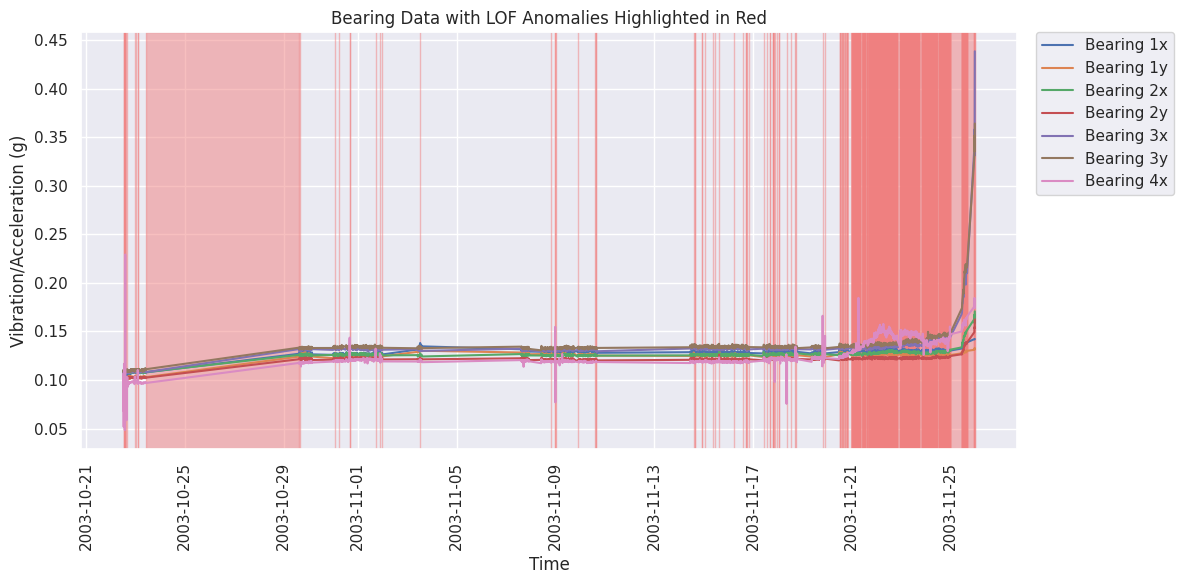

In [72]:
merged_data['Anomaly_LOF'] = lof_results['Anomaly']

plt.figure(figsize=(12, 6))

for col in merged_data.columns[:-4]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_LOF'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with LOF Anomalies Highlighted in Red")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

Need to Optimise it as Well. This is also detecting TOO much ANOMALIES

Adjust the contamination Parameter

In [73]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01, novelty=True)
lof.fit(X_train)
train_scores = lof.decision_function(X_train)
test_scores = lof.decision_function(X_test)

train_anomalies = lof.predict(X_train)
test_anomalies = lof.predict(X_test)

In [74]:
lof_results = pd.DataFrame(index=X_train.index.append(X_test.index))
lof_results['Score'] = np.concatenate([train_scores, test_scores])
lof_results['Anomaly'] = np.concatenate([train_anomalies, test_anomalies])

In [75]:
lof_results['Anomaly'] = lof_results['Anomaly'] == -1

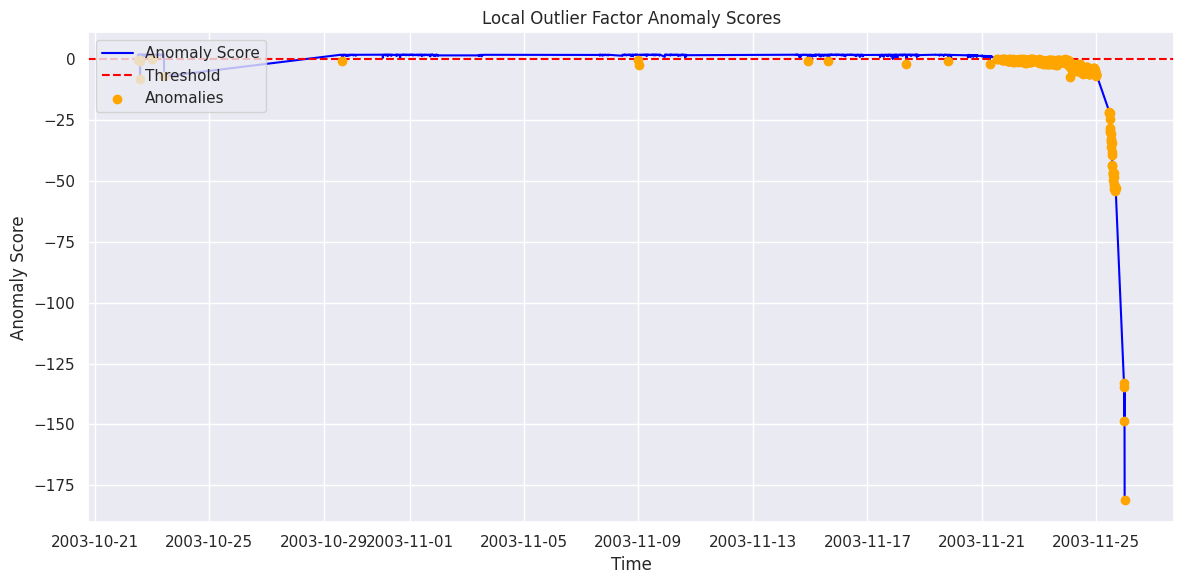

In [76]:
plt.figure(figsize=(12,6))
plt.plot(lof_results.index, lof_results['Score'], label='Anomaly Score', color='blue')
plt.axhline(y=0, color='red', linestyle='--', label='Threshold')
plt.scatter(lof_results[lof_results['Anomaly']].index,
            lof_results[lof_results['Anomaly']]['Score'],
            color='orange', label='Anomalies', zorder=5)
plt.title('Local Outlier Factor Anomaly Scores')
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

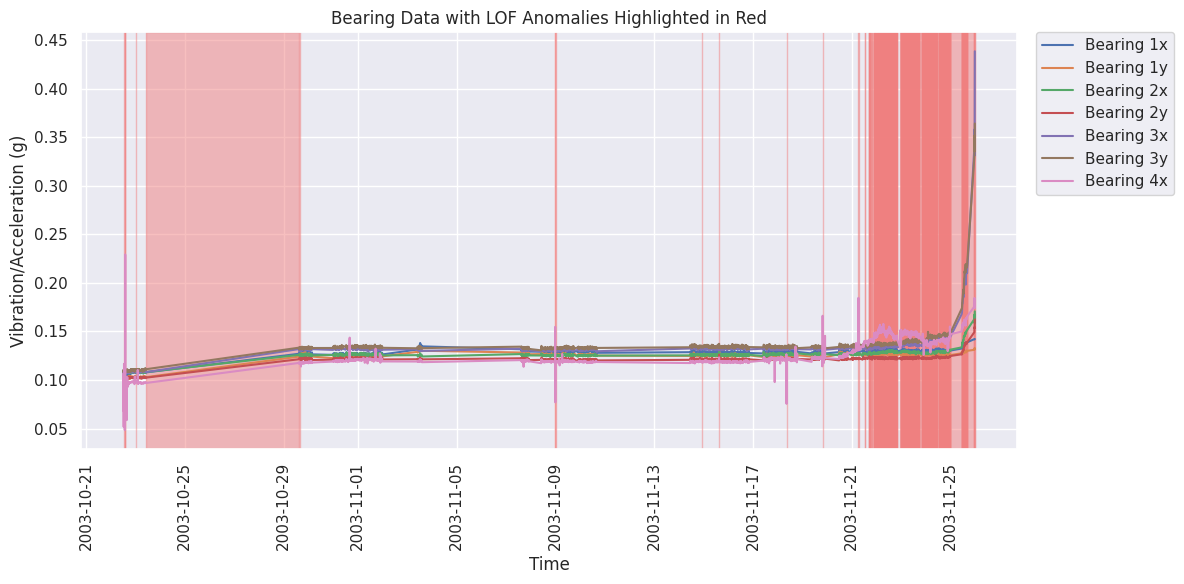

In [77]:
merged_data['Anomaly_LOF'] = lof_results['Anomaly']

plt.figure(figsize=(12, 6))

for col in merged_data.columns[:-4]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_LOF'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with LOF Anomalies Highlighted in Red")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

Adjust the n_neighbors Parameter

In [78]:
lof = LocalOutlierFactor(n_neighbors=35, contamination=0.01, novelty=True)
lof.fit(X_train)

LocalOutlierFactor(contamination=0.01, n_neighbors=35, novelty=True)

In [79]:
train_scores = lof.decision_function(X_train)
test_scores = lof.decision_function(X_test)

train_anomalies = lof.predict(X_train)
test_anomalies = lof.predict(X_test)

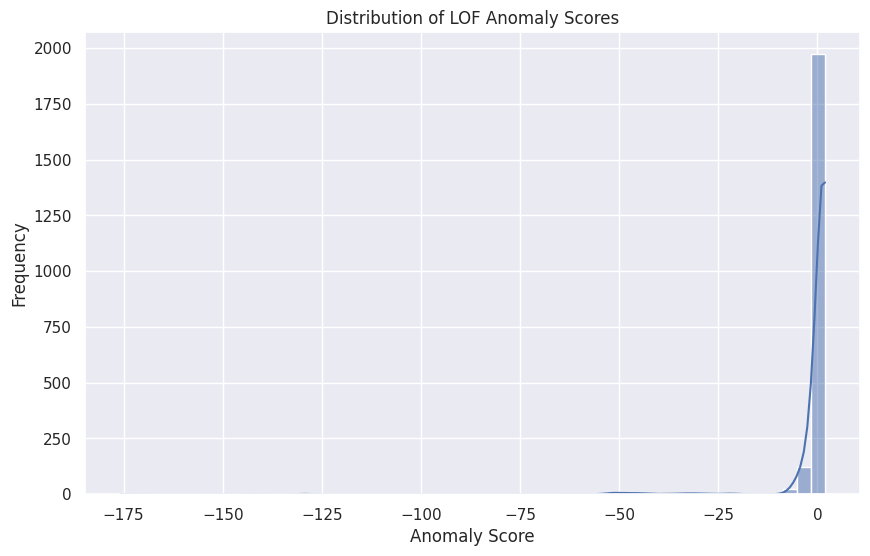

In [80]:
scores = np.concatenate([train_scores, test_scores])
plt.figure(figsize=(10,6))
sns.histplot(scores, bins=50, kde=True)
plt.title('Distribution of LOF Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()

In [87]:
threshold = np.percentile(scores, 1)
print(f"Custom Threshold: {threshold}")

Custom Threshold: -39.99143685605407


In [88]:
lof_results = pd.DataFrame(index=X_train.index.append(X_test.index))
lof_results['Score'] = scores
lof_results['Anomaly'] = scores < threshold

merged_data['Anomaly_LOF'] = lof_results['Anomaly'].values

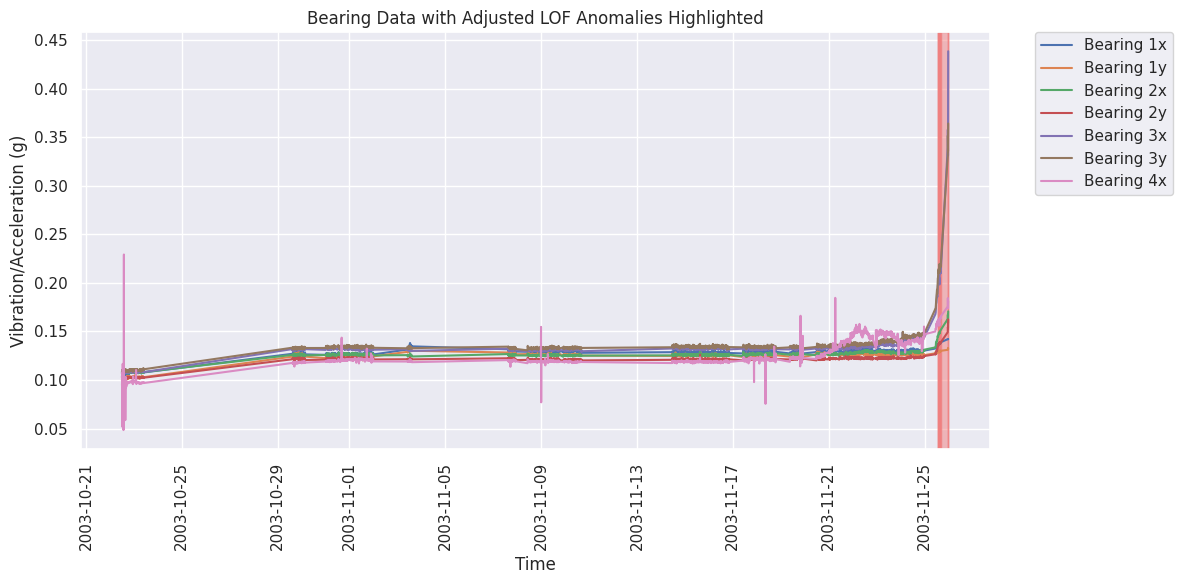

In [89]:
plt.figure(figsize=(12, 6))

for col in merged_data.columns[:-4]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_LOF'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with Adjusted LOF Anomalies Highlighted")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()


This looks better and is detecting anomalies at the end.

In [90]:
contamination_values = [0.005, 0.01, 0.02]
n_neighbors_values = [20, 35, 50]

for contamination in contamination_values:
    for n_neighbors in n_neighbors_values:
        lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, novelty=True)
        lof.fit(X_train)
        test_anomalies = lof.predict(X_test)
        n_anomalies = np.sum(test_anomalies == -1)
        print(f"Contamination: {contamination}, n_neighbors: {n_neighbors}, Anomalies Detected: {n_anomalies}")

Contamination: 0.005, n_neighbors: 20, Anomalies Detected: 272
Contamination: 0.005, n_neighbors: 35, Anomalies Detected: 277
Contamination: 0.005, n_neighbors: 50, Anomalies Detected: 202
Contamination: 0.01, n_neighbors: 20, Anomalies Detected: 436
Contamination: 0.01, n_neighbors: 35, Anomalies Detected: 437
Contamination: 0.01, n_neighbors: 50, Anomalies Detected: 417
Contamination: 0.02, n_neighbors: 20, Anomalies Detected: 497
Contamination: 0.02, n_neighbors: 35, Anomalies Detected: 489
Contamination: 0.02, n_neighbors: 50, Anomalies Detected: 475


In [91]:
merged_data

Bearing 1x  Bearing 1y  Bearing 2x  Bearing 2y  \
time                                                                  
2003-10-22 12:06:24    0.104148    0.100253    0.107147    0.102004   
2003-10-22 12:09:13    0.103651    0.099854    0.108189    0.102920   
2003-10-22 12:14:13    0.105039    0.101543    0.108543    0.104042   
2003-10-22 12:19:13    0.104900    0.101573    0.108152    0.103378   
2003-10-22 12:24:13    0.104779    0.102181    0.107943    0.102629   
...                         ...         ...         ...         ...   
2003-11-25 16:07:32    0.138784    0.130001    0.151358    0.138561   
2003-11-25 23:13:21    0.142147    0.131042    0.162772    0.149214   
2003-11-25 23:19:56    0.142098    0.131348    0.167258    0.154300   
2003-11-25 23:29:56    0.141889    0.132988    0.158432    0.153226   
2003-11-25 23:39:56    0.142014    0.131698    0.170618    0.162325   

                     Bearing 3x  Bearing 3y  Bearing 4x  Bearing 4y  \
time                                                                  
2003-10-22 12:06:24    0.106149    0.108150    0.094803    0.099513   
2003-10-22 12:09:13    0.106661    0.108458    0.095070    0.093587   
2003-10-22 12:14:13    0.108740    0.109875    0.096158    0.098299   
2003-10-22 12:19:13    0.108068    0.110010    0.096814    0.098602   
2003-10-22 12:24:13    0.108454    0.109350    0.096358    0.098471   
...                         ...         ...         ...         ...   
2003-11-25 16:07:32    0.209843    0.217346    0.165271    0.154710   
2003-11-25 23:13:21    0.339327    0.330122    0.175640    0.163224   
2003-11-25 23:19:56    0.357823    0.351640    0.184356    0.165720   
2003-11-25 23:29:56    0.331172    0.335432    0.174025    0.161537   
2003-11-25 23:39:56    0.438427    0.364037    0.181261    0.168055   

                     Anomaly_ISO  Anomaly_OCSVM  Anomaly_LOF  
time                                                          
2003-10-22 12:06:24         True          False        False  
2003-10-22 12:09:13         True          False        False  
2003-10-22 12:14:13        False          False        False  
2003-10-22 12:19:13        False          False        False  
2003-10-22 12:24:13        False          False        False  
...                          ...            ...          ...  
2003-11-25 16:07:32         True           True         True  
2003-11-25 23:13:21         True           True         True  
2003-11-25 23:19:56         True           True         True  
2003-11-25 23:29:56         True           True         True  
2003-11-25 23:39:56         True           True         True  

[2156 rows x 11 columns]

In [92]:
merged_data['Anomaly_ISO'] = iso_forest_results['Anomaly_Custom'].values
merged_data['Anomaly_OCSVM'] = ocsvm_results['Anomaly_Custom'].values
merged_data['Anomaly_LOF'] = lof_results['Anomaly'].values

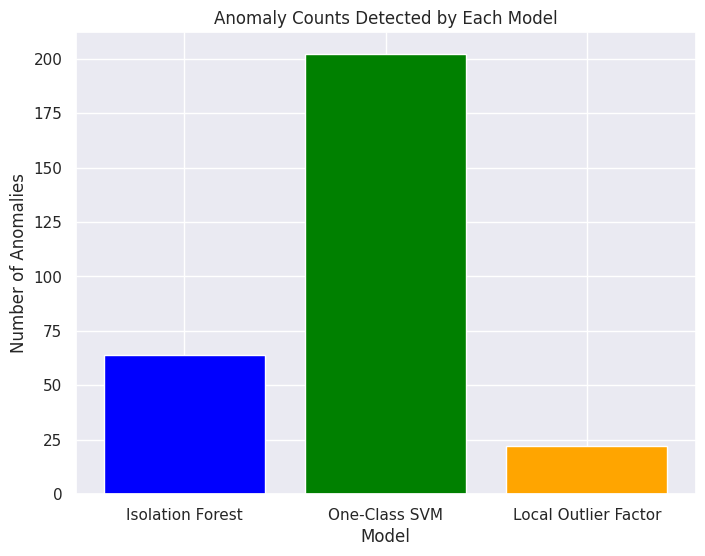

In [93]:
# Plot 1: Anomaly counts detected by each model (bar plot)
anomalies_iso = merged_data['Anomaly_ISO'].sum()
anomalies_ocsvm = merged_data['Anomaly_OCSVM'].sum()
anomalies_lof = merged_data['Anomaly_LOF'].sum()

plt.figure(figsize=(8, 6))
models = ['Isolation Forest', 'One-Class SVM', 'Local Outlier Factor']
anomaly_counts = [anomalies_iso, anomalies_ocsvm, anomalies_lof]
plt.bar(models, anomaly_counts, color=['blue', 'green', 'orange'])
plt.title('Anomaly Counts Detected by Each Model')
plt.xlabel('Model')
plt.ylabel('Number of Anomalies')
plt.show()

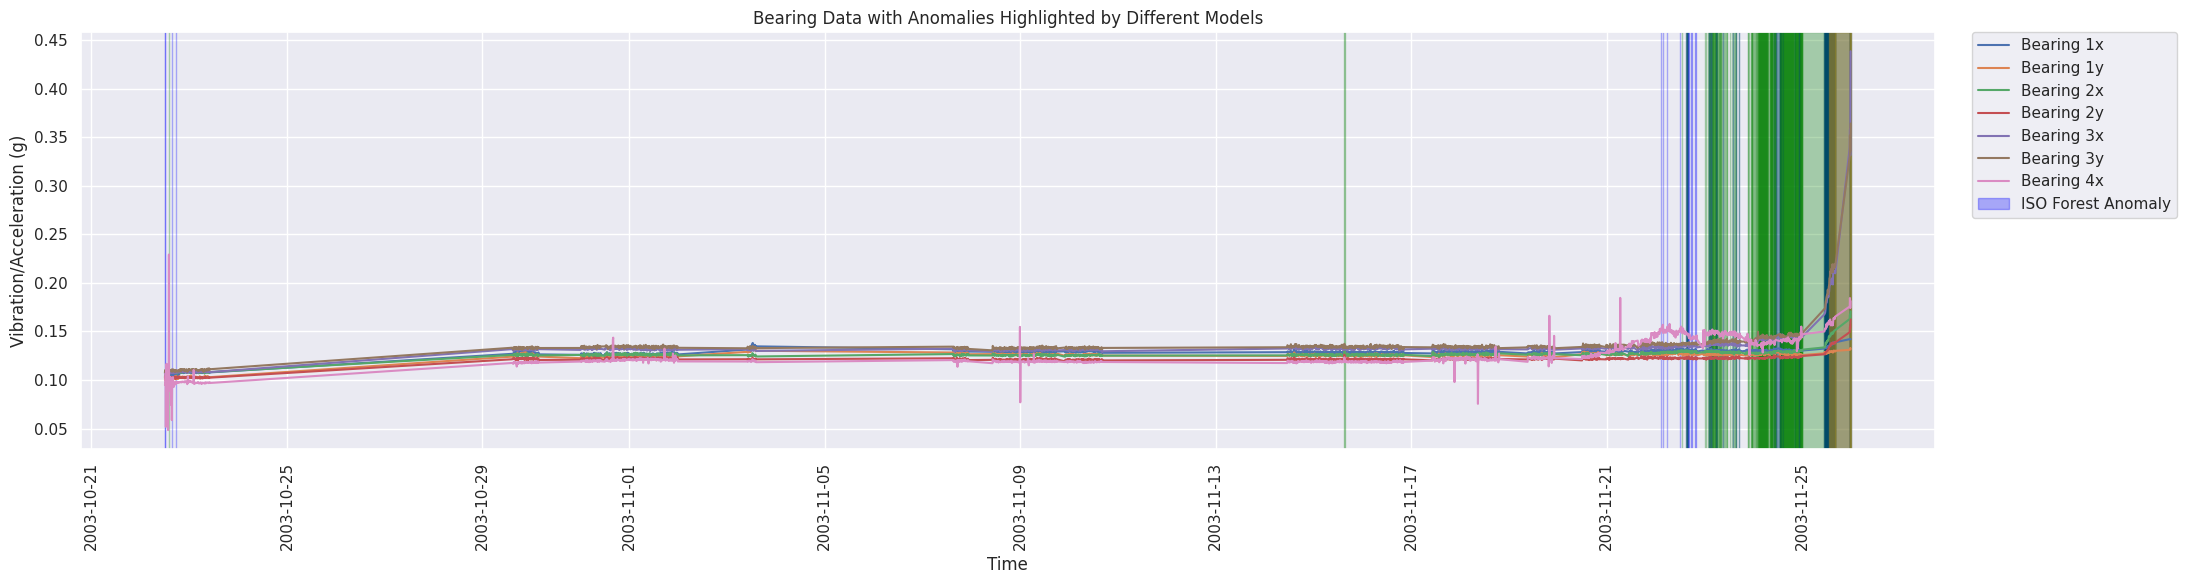

In [94]:
#Time series plot of vibration/acceleration data with anomalies highlighted

plt.figure(figsize=(22, 6))
for col in merged_data.columns[:-4]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_ISO'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='blue', alpha=0.3, label="ISO Forest Anomaly" if i == 0 else "")
    if merged_data['Anomaly_OCSVM'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='green', alpha=0.3, label="OCSVM Anomaly" if i == 0 else "")
    if merged_data['Anomaly_LOF'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='orange', alpha=0.3, label="LOF Anomaly" if i == 0 else "")

plt.title("Bearing Data with Anomalies Highlighted by Different Models")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

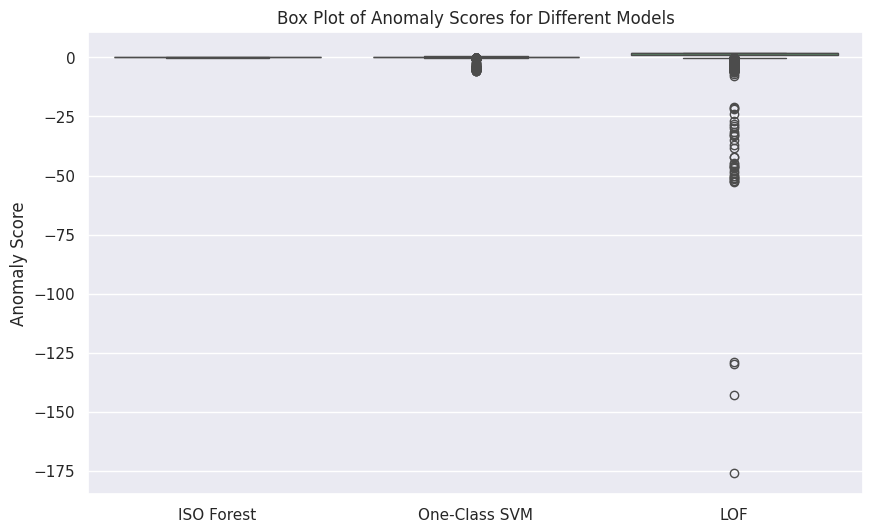

In [95]:
comparison_df = pd.DataFrame({
    'ISO Forest': iso_forest_results['Score'],
    'One-Class SVM': ocsvm_results['Score'],
    'LOF': lof_results['Score']
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=comparison_df)
plt.title('Box Plot of Anomaly Scores for Different Models')
plt.ylabel('Anomaly Score')
plt.show()

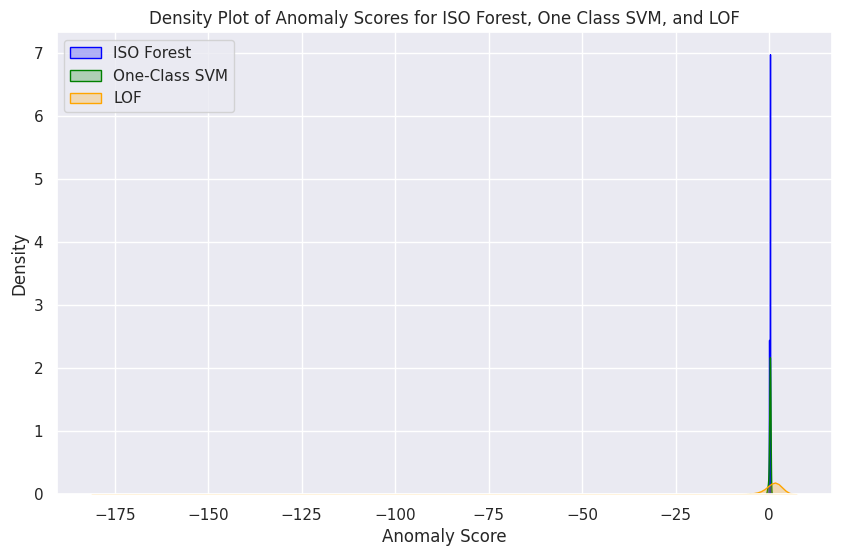

In [103]:
plt.figure(figsize=(10, 6))
sns.kdeplot(iso_forest_results['Score'], label='ISO Forest', color='blue', shade=True)
sns.kdeplot(ocsvm_results['Score'], label='One-Class SVM', color='green', shade=True)
sns.kdeplot(lof_results['Score'], label='LOF', color='orange', shade=True)
plt.title('Density Plot of Anomaly Scores for ISO Forest, One Class SVM, and LOF')
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
# plt.yscale('log')  # 設定 y 軸為對數刻度
plt.legend()
plt.show()

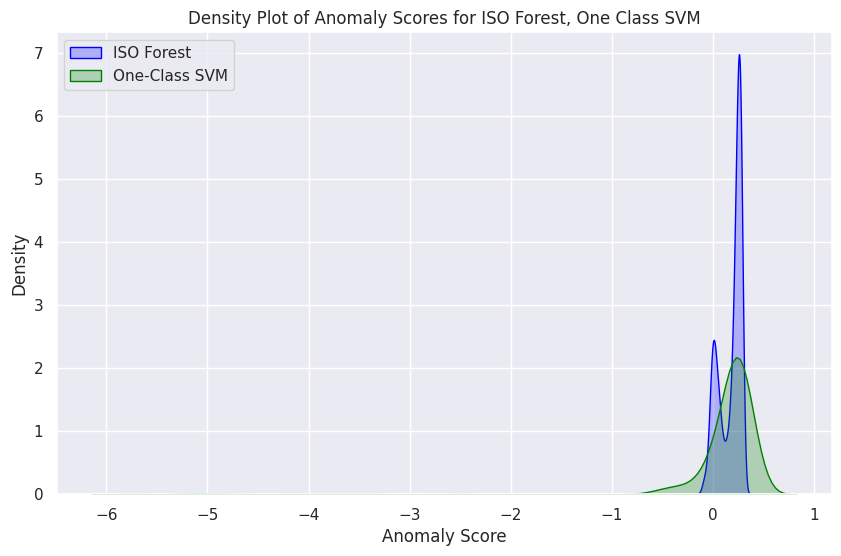

In [104]:
plt.figure(figsize=(10, 6))
sns.kdeplot(iso_forest_results['Score'], label='ISO Forest', color='blue', shade=True)
sns.kdeplot(ocsvm_results['Score'], label='One-Class SVM', color='green', shade=True)
plt.title('Density Plot of Anomaly Scores for ISO Forest, One Class SVM')
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
# plt.yscale('log')  # 設定 y 軸為對數刻度
plt.legend()
plt.show()

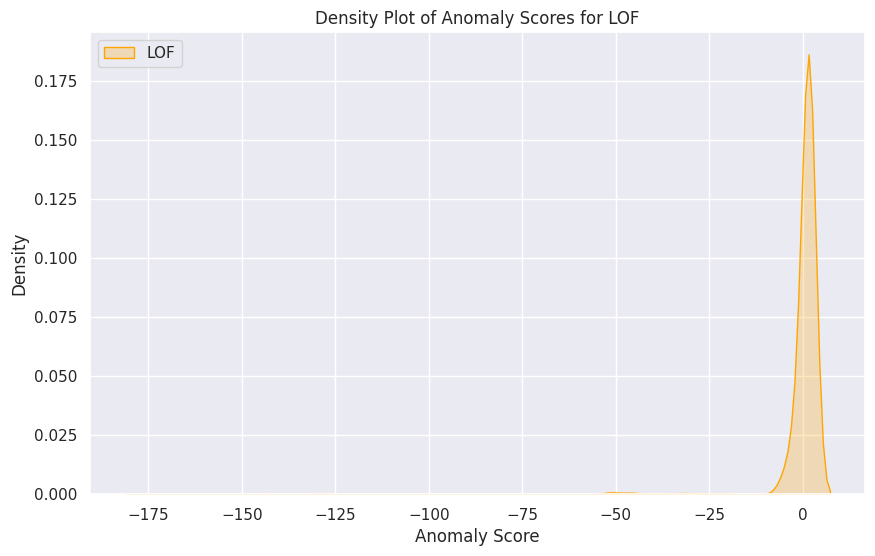

In [105]:
plt.figure(figsize=(10, 6))
sns.kdeplot(lof_results['Score'], label='LOF', color='orange', shade=True)
plt.title('Density Plot of Anomaly Scores for LOF')
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.legend()
plt.show()